In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galois
from classical_code import *
from quantum_code import *
import os

In [13]:
GF = galois.GF(2)
# ccode = read_code("../codes/ccodes/24_18_3_4.code")
ccode = read_code("../codes/ccodes/8_6_3_4.code")

H = np.zeros((ccode.m, ccode.n), dtype=int)
for i in range(ccode.m):
    for j in range(ccode.n):
        if (j in ccode.check_nbhd[i]):
            H[i][j] = 1


# H = np.array([
#     [1,0,1,0,1,0],
#     [0,1,0,0,1,1],
#     [1,0,1,1,0,0],
#     [0,1,1,1,0,0]
# ])
H = np.array([[1, 1, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 1, 1]])
m, n = H.shape
H = GF(H)
print(H)


[[1 1 1 0 0]
 [0 1 1 1 0]
 [0 0 1 1 1]]


In [14]:
def gaussian_reduction(H):
    m, n = H.shape

    H = GF(H)
    Hhat = GF(H.copy())
    K = GF(np.eye(n, dtype=int))
    pik = set(np.arange(n))

    for j in range(n):
        i = 0
        while ((i < m-1) and (Hhat[i][j] != 1)):
            i += 1
        if Hhat[i][j] == 1:
            pik ^= {j}
            for l in range(j+1, n):
                if Hhat[i][l] == 1:
                    Hhat[:,l] = Hhat[:,j] ^ Hhat[:,l]
                    K[:,l] = K[:,j] ^ K[:,l]

    return K, pik

In [15]:
Lx = []
Lz = []

K, pik = gaussian_reduction(H)
I = np.eye(n, dtype=int)

for i in pik:
    for j in pik:
        tmp = np.kron(K[:,i], I[:,j])
        Lz.append(np.concatenate([tmp, np.zeros(m**2, dtype=int)]))

        tmp = np.kron(I[:,i], K[:,j])
        Lx.append(np.concatenate([tmp, np.zeros(m**2, dtype=int)]))

K, pik = gaussian_reduction(H.T)
I = np.eye(H.T.shape[1], dtype=int)

for i in pik:
    for j in pik:
        tmp = np.kron(K[:,i], I[:,j])
        Lx.append(np.concatenate([np.zeros(n**2, dtype=int), tmp]))

        tmp = np.kron(I[:,i], K[:,j])
        Lz.append(np.concatenate([np.zeros(n**2, dtype=int), tmp]))

Lx = np.array(Lx)
Lz = np.array(Lz)

In [16]:
for l in Lx:
    print(np.count_nonzero(l))

3
3
3
3


In [17]:
H = np.array(H)
Hx = np.hstack([np.kron(H, np.eye(H.shape[1], dtype=int)), np.kron(np.eye(H.shape[0], dtype=int), H.T)])
Hz = np.hstack([np.kron(np.eye(H.shape[1], dtype=int), H), np.kron(H.T, np.eye(H.shape[0], dtype=int))])
cm, cn = Hx.shape

Hx_inds = [np.where(Hx[i])[0] for i in range(Hx.shape[0])]
Hz_inds = [np.where(Hz[i])[0] for i in range(Hz.shape[0])]

xL_inds = [np.where(x)[0] for x in Lx]
zL_inds = [np.where(z)[0] for z in Lz]
k = len(xL_inds)

qcode = QuantumCode(cn, k, Hz.shape[0], Hz.shape[0],
                    0, 0,
                    Hx_inds, Hz_inds, xL_inds, zL_inds, [])
# write_qcode("../codes/qcodes/" + f"/HGP_{cn}_{k}.qcode", qcode)


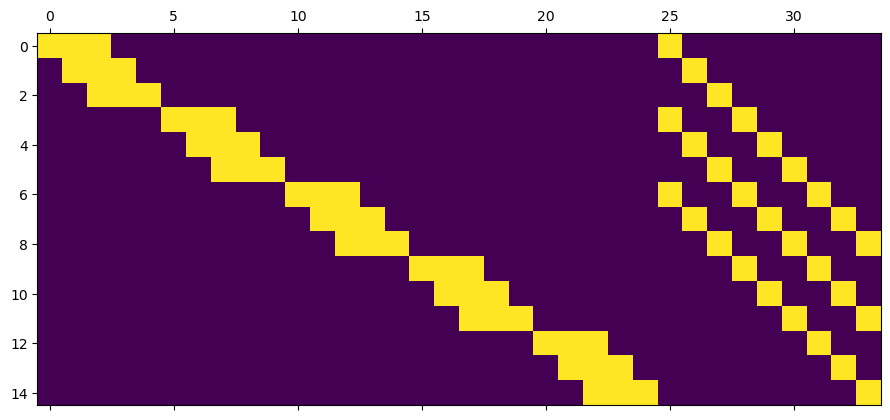

In [18]:
plt.matshow(np.array(Hz))

In [19]:
np.count_nonzero(Hx, axis=1)

array([4, 5, 6, 5, 4, 4, 5, 6, 5, 4, 4, 5, 6, 5, 4], dtype=int64)

In [20]:
xgens = []
zgens = []

for i in range(Hx.shape[0]):
    xgens.append((Hx[i][:n**2].reshape(n,n), Hx[i][n**2:].reshape(m,m)))
    zgens.append((Hz[i][:n**2].reshape(n,n), Hz[i][n**2:].reshape(m,m)))

xlogs = []
zlogs = []
for i in range(Lx.shape[0]):
    xlogs.append((Lx[i][:n**2].reshape(n,n), Lx[i][n**2:].reshape(m,m)))
    zlogs.append((Lz[i][:n**2].reshape(n,n), Lz[i][n**2:].reshape(m,m)))

In [21]:
H.T

array([[1, 0, 0],
       [1, 1, 0],
       [1, 1, 1],
       [0, 1, 1],
       [0, 0, 1]], dtype=uint8)

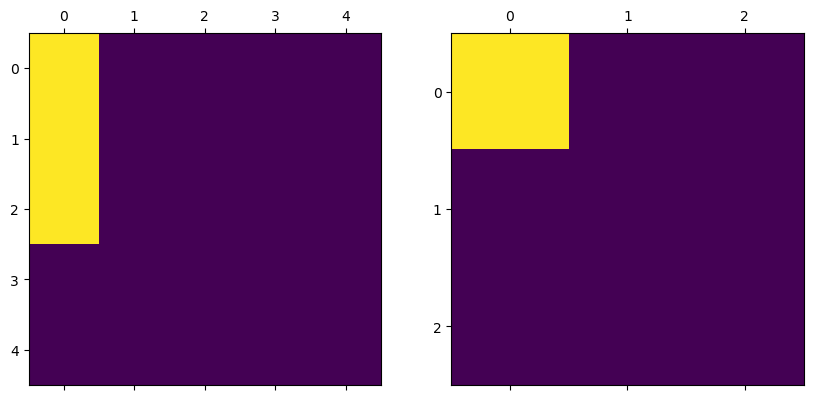

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)

axes[0].matshow(xgens[0][0])
axes[1].matshow(xgens[0][1])

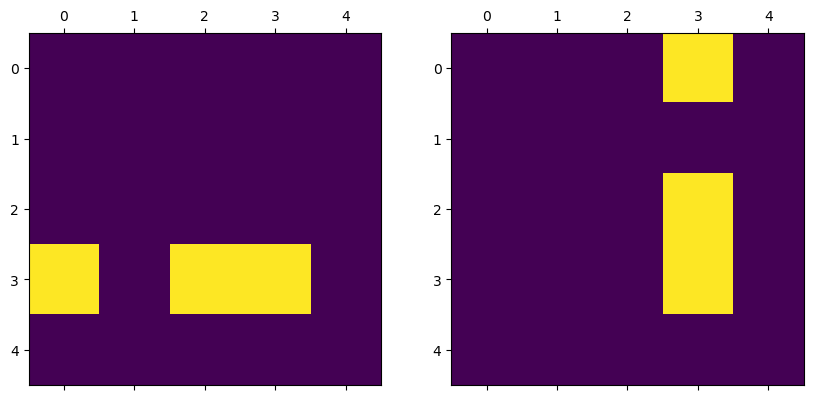

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)

ind = 0
axes[0].matshow(xlogs[ind][0])
axes[1].matshow(zlogs[ind][0])

In [24]:
inds = np.arange(Hx.shape[1])
left, right = (inds[:n**2].reshape(n,n), inds[n**2:].reshape(m,m))
print(left)
print(right)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[[25 26 27]
 [28 29 30]
 [31 32 33]]


In [198]:
def assign_qubits(left, right):
    pairs = np.concatenate([np.diagonal(left), np.diagonal(right)]).reshape(-1, 2)

    upper_triangle_inds = np.triu_indices(left.shape[0], k=1)
    for i, j in zip(*upper_triangle_inds):
        tmp = np.array([left[i][j], left[j][i]])
        pairs = np.vstack([pairs, tmp])

    upper_triangle_inds = np.triu_indices(right.shape[0], k=1)
    for i, j in zip(*upper_triangle_inds):
        tmp = np.array([right[i][j], right[j][i]])
        pairs = np.vstack([pairs, tmp])

    return pairs

pairs = assign_qubits(left, right)
pairs

array([[  0,  17],
       [ 34,  51],
       [ 68,  85],
       [102, 119],
       [136, 153],
       [170, 187],
       [204, 221],
       [238, 255],
       [256, 269],
       [282, 295],
       [308, 321],
       [334, 347],
       [360, 373],
       [386, 399],
       [  1,  16],
       [  2,  32],
       [  3,  48],
       [  4,  64],
       [  5,  80],
       [  6,  96],
       [  7, 112],
       [  8, 128],
       [  9, 144],
       [ 10, 160],
       [ 11, 176],
       [ 12, 192],
       [ 13, 208],
       [ 14, 224],
       [ 15, 240],
       [ 18,  33],
       [ 19,  49],
       [ 20,  65],
       [ 21,  81],
       [ 22,  97],
       [ 23, 113],
       [ 24, 129],
       [ 25, 145],
       [ 26, 161],
       [ 27, 177],
       [ 28, 193],
       [ 29, 209],
       [ 30, 225],
       [ 31, 241],
       [ 35,  50],
       [ 36,  66],
       [ 37,  82],
       [ 38,  98],
       [ 39, 114],
       [ 40, 130],
       [ 41, 146],
       [ 42, 162],
       [ 43, 178],
       [ 44,

In [199]:
def iceberglogicals(n):
    icebergX = np.zeros(shape=(n-2,2), dtype=int)
    icebergZ = np.zeros(shape=(n-2,2), dtype=int)

    for i in range(n-2):
        icebergX[i] = np.array([0,i+1])
        icebergZ[i] = np.array([i+1,n-1])

    return icebergX, icebergZ

iceberg642Xlogicals = np.array([
    [1,2],
    [0,1],
    [4,5],
    [3,4],
])

iceberg642Zlogicals = np.array([
    [0,1],
    [1,2],
    [3,4],
    [4,5]
])

ibn = 4
ibk = ibn-2
icebergX = np.ones(ibn, dtype=int)
# icebergZ = np.ones(ibn, dtype=int)

# if (ibn == 6):
#     icebergXlogicals, icebergZlogicals = iceberg642Xlogicals, iceberg642Zlogicals
# else:
icebergXlogicals, icebergZlogicals = iceberglogicals(ibn)
print(icebergXlogicals)
print(icebergZlogicals)

[[0 1]
 [0 2]]
[[1 3]
 [2 3]]


In [200]:
# Hx, Hz, Lx, Lz = qcode.to_numpy()
concatenatedStabilizersQED = np.kron(np.eye(Hx.shape[1]//ibk, dtype=int), icebergX) # ibk | Hx.shape[1] required

concatenatedStabilizersXQEC = np.zeros(shape=(Hx.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)
concatenatedStabilizersZQEC = np.zeros(shape=(Hz.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)

for i, r in enumerate(Hx):
    # print(np.where(r))
    for x in np.where(r)[0]:
        iceberg_block = np.where(pairs == x)[0][0]
        iceberg_log = np.where(pairs == x)[1][0]
        # print(iceberg_block, iceberg_log)
        concatenatedStabilizersXQEC[i][icebergXlogicals[iceberg_log]+(ibn*iceberg_block)] ^= 1

for i, r in enumerate(Hz):
    for z in np.where(r)[0]:
        iceberg_block = np.where(pairs == z)[0][0]
        iceberg_log = np.where(pairs == z)[1][0]
        concatenatedStabilizersZQEC[i][icebergZlogicals[iceberg_log]+(ibn*iceberg_block)] ^= 1

concatenatedHx = np.vstack([concatenatedStabilizersXQEC, concatenatedStabilizersQED][::-1])
concatenatedHz = np.vstack([concatenatedStabilizersZQEC, concatenatedStabilizersQED][::-1])

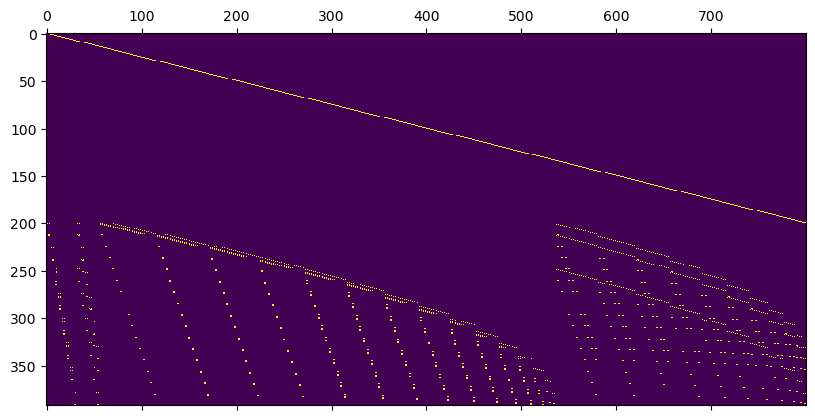

In [201]:
plt.matshow(concatenatedHz)

In [202]:
concatenatedxL = np.zeros(shape=(Lx.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)
concatenatedzL = np.zeros(shape=(Lz.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)

for i, r in enumerate(Lx):
    for x in np.where(r)[0]:
        iceberg_block = np.where(pairs == x)[0][0]
        iceberg_log = np.where(pairs == x)[1][0]
        # print(iceberg_block, iceberg_log)
        concatenatedxL[i][icebergXlogicals[iceberg_log]+(ibn*iceberg_block)] ^= 1

for i, r in enumerate(Lz):
    for z in np.where(r)[0]:
        iceberg_block = np.where(pairs == z)[0][0]
        iceberg_log = np.where(pairs == z)[1][0]
        concatenatedzL[i][icebergZlogicals[iceberg_log]+(ibn*iceberg_block)] ^= 1

xL_inds = [np.where(x)[0] for x in concatenatedxL]
zL_inds = [np.where(z)[0] for z in concatenatedzL]

m, n = concatenatedHx.shape
k = len(xL_inds)

Hx_inds = [np.where(concatenatedHx[i])[0] for i in range(concatenatedHx.shape[0])]
Hz_inds = [np.where(concatenatedHz[i])[0] for i in range(concatenatedHz.shape[0])]

qcode = QuantumCode(n, k, concatenatedHx.shape[0], concatenatedHz.shape[0],
                    concatenatedStabilizersQED.shape[0], concatenatedStabilizersQED.shape[0],
                    Hx_inds, Hz_inds, xL_inds, zL_inds, list(pairs))
write_qcode("../codes/qcodes/" + f"/HGP_C{ibn}{ibk}2_{n}_{k}.qcode", qcode)

In [203]:
zL_inds

[array([ 25,  27, 157, 159, 301, 303, 341, 343, 409, 411, 461, 463, 481,
        483, 497, 499], dtype=int64),
 array([161, 163, 305, 307, 345, 347, 413, 415, 465, 467, 485, 487, 501,
        503, 513, 515], dtype=int64),
 array([165, 167, 309, 311, 349, 351, 417, 419, 469, 471, 489, 491, 505,
        507, 517, 519], dtype=int64),
 array([169, 171, 313, 315, 353, 355, 421, 423, 473, 475, 493, 495, 509,
        511, 521, 523], dtype=int64),
 array([157, 159, 209, 211, 301, 303, 377, 379, 409, 411, 437, 439, 461,
        463, 514, 515], dtype=int64),
 array([ 26,  27, 161, 163, 213, 215, 305, 307, 381, 383, 413, 415, 441,
        443, 465, 467], dtype=int64),
 array([165, 167, 217, 219, 309, 311, 385, 387, 417, 419, 445, 447, 469,
        471, 525, 527], dtype=int64),
 array([169, 171, 221, 223, 313, 315, 389, 391, 421, 423, 449, 451, 473,
        475, 529, 531], dtype=int64),
 array([209, 211, 257, 259, 341, 343, 409, 411, 437, 439, 461, 463, 481,
        483, 518, 519], dtype=int64),
 

In [204]:
xL_inds

[array([ 24,  25, 156, 158, 300, 302, 340, 342, 408, 410, 460, 462, 480,
        482, 496, 498], dtype=int64),
 array([156, 158, 208, 210, 300, 302, 376, 378, 408, 410, 436, 438, 460,
        462, 512, 513], dtype=int64),
 array([208, 210, 256, 258, 340, 342, 408, 410, 436, 438, 460, 462, 480,
        482, 516, 517], dtype=int64),
 array([100, 102, 256, 258, 300, 302, 376, 378, 436, 438, 460, 462, 480,
        482, 496, 498, 520, 521], dtype=int64),
 array([160, 162, 304, 306, 344, 346, 412, 414, 464, 466, 484, 486, 500,
        502, 512, 514], dtype=int64),
 array([ 24,  26, 160, 162, 212, 214, 304, 306, 380, 382, 412, 414, 440,
        442, 464, 466], dtype=int64),
 array([212, 214, 260, 262, 344, 346, 412, 414, 440, 442, 464, 466, 484,
        486, 524, 525], dtype=int64),
 array([104, 106, 260, 262, 304, 306, 380, 382, 440, 442, 464, 466, 484,
        486, 500, 502, 528, 529], dtype=int64),
 array([164, 166, 308, 310, 348, 350, 416, 418, 468, 470, 488, 490, 504,
        506, 516, 5